In [10]:
#数据预处理
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import LabelEncoder
from dummyPy import OneHotEncoder
import random
import pickle  # 存储临时变量

## 读文件
file_path = ''
train_file = file_path + 'train'
test_file  = file_path + 'test'
col_counts_file = file_path + 'col_counts'

## 存储标签编码和one-hot编码
fp_lb_enc = file_path + 'lb_enc'
fp_oh_enc = file_path + 'oh_enc'

##==================== 数据预处理 ====================##
# 包括id, click的feature
cols = ['hour', 'C1', 'banner_pos', 'site_id', 'site_domain', 'site_category', 'app_id', 'app_domain', 'app_category', 'device_id', 'device_ip', 'device_model', 'device_type', 'device_conn_type', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21']
# 非features字段
cols_train = ['id', 'click']
cols_test  = ['id']
cols_train.extend(cols)
cols_test.extend(cols)

## 数据加载
print('loading data...')
# 只读10行
df_train_sample = pd.read_csv(train_file, nrows = 10, encoding = 'utf-8')
#print(df_train_sample)

# sample前10000行数据
df_train_org = pd.read_csv(train_file, nrows=10000, encoding = 'utf-8')
df_test_org  = pd.read_csv(test_file, nrows=10000, encoding = 'utf-8')
df_train_org.to_csv('train_sample.csv', index=False)
df_test_org.to_csv('test_sample.csv', index=False)
print('sample saved')

loading data...
sample saved


loading data...


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:71: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.


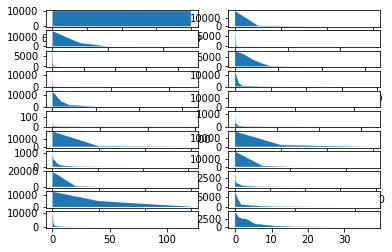

label_encoder saved
onehot_encoder saved


In [13]:
#数据预处理
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import LabelEncoder
from dummyPy import OneHotEncoder
import random
import pickle  # 存储临时变量

## 读文件
file_path = ''
train_file = file_path + 'train_sample.csv'
test_file  = file_path + 'test_sample.csv'

## 下采样写文件
col_counts_file = file_path + 'col_counts'

## 存储标签编码和one-hot编码
label_encoder_file = file_path + 'label_encoder'
onehot_encoder_file = file_path + 'onehot_encoder'

##==================== 数据预处理 ====================##
# 包括id, click的feature
cols = ['hour', 'C1', 'banner_pos', 'site_id', 'site_domain', 'site_category', 'app_id', 'app_domain', 'app_category', 'device_id', 'device_ip', 'device_model', 'device_type', 'device_conn_type', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21']
# 非features字段
cols_train = ['id', 'click']
cols_test  = ['id']
cols_train.extend(cols)
cols_test.extend(cols)

## 数据加载
print('loading data...')
# 只读10行
df_train_sample = pd.read_csv(train_file, nrows = 10)
#print(df_train_sample)

# 可以分块处理文件
df_train_org = pd.read_csv(train_file, chunksize = 10000000, iterator = True)
df_test_org  = pd.read_csv(test_file,  chunksize = 10000000, iterator = True)

#----- 统计字典 不同值个数 -----#
##  统计sample中的字段 不同值个数
cols_counts = {} 
for col in cols:
    cols_counts[col] = df_train_sample[col].value_counts()
#print(cols_counts)
## 统计训练集中的字段 不同值个数
for chunk in df_train_org:
    for col in cols:
        cols_counts[col] = cols_counts[col].append(chunk[col].value_counts())
## 统计测试集中的字段 不同值个数
for chunk in df_test_org:
    for col in cols:
        cols_counts[col] = cols_counts[col].append(chunk[col].value_counts())
## 统计
for col in cols:
    cols_counts[col] = cols_counts[col].groupby(cols_counts[col].index).sum()
    # 排序
    cols_counts[col] = cols_counts[col].sort_values(ascending=False)   
## 存储value_counts
pickle.dump(cols_counts, open(col_counts_file, 'wb'))
#print(cols_counts)


## 绘制分布
fig = plt.figure(1)
for i, col in enumerate(cols):
    # 一共22个feature，放到11*2个figure里
    ax = fig.add_subplot(11, 2, i+1)
    ax.fill_between(np.arange(len(cols_counts[col])), cols_counts[col].get_values())
    # ax.set_title(col)
plt.show()

## 每个字段，只保存前k个字段值
k = 100
col_index = {}
for col in cols:
    col_index[col] = cols_counts[col][0: k-1].index
    #print(col, col_index[col])

## 对分类变量进行标签编码
lb_enc = {}
for col in cols:
    # 超过前100个value，设置为other
    col_index[col] = np.append(col_index[col], 'other')

for col in cols:
    lb_enc[col] = LabelEncoder()
    lb_enc[col].fit(col_index[col])
    
## 存储标签编码
pickle.dump(lb_enc, open(label_encoder_file, 'wb'))
print(label_encoder_file + ' saved')
## one-hot编码
oh_enc = OneHotEncoder(cols)

for chunk in df_train_org:
    oh_enc.fit(chunk)
for chunk in df_test_org:
    oh_enc.fit(chunk)

## 存储one-hot编码
pickle.dump(oh_enc, open(onehot_encoder_file, 'wb'))
print(onehot_encoder_file + ' saved')

onehot_encoder
LR model saved
[]


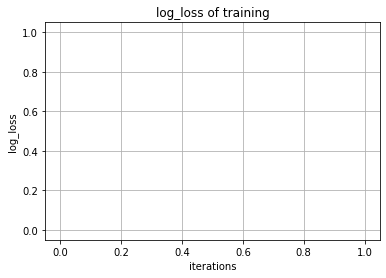

2508

In [15]:
# 使用LR模型对Avazu CTR进行预估
import pandas as pd
import numpy as np
from dummyPy import OneHotEncoder  # 超大规模数据one-hot编码
from sklearn.linear_model import SGDClassifier  # 梯度下降分类
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt 
import pickle

##==================== 设置文件路径File-Path (fp) ====================##
file_path = ''
train_file = file_path + "train_sample.csv"
test_file  = file_path + "test_sample.csv"

# one-hot编码保存
onehot_encoder_file = file_path + "onehot_encoder"
# LR模型保存
lr_model_file = file_path + "lr/lr_model"
# submission文件保存
submission_file = file_path + "lr/LR_submission.csv"

##==================== LR 训练 ====================##
print(onehot_encoder_file)
onehot_encoder = pickle.load(open(onehot_encoder_file, 'rb'))

# 一个chunk块为5万行
chunksize = 50000
df_train = pd.read_csv(train_file, dtype={'id':str}, index_col=None, chunksize=chunksize, iterator=True)

# 使用LogLoss作为LR的损失函数
lr_model = SGDClassifier(loss='log')  
scores = []

# 使用k和i调整训练规模，训练样本 = 所有样本 / k
k = 100  
i = 1
for chunk in df_train:
    # 根据K drop掉样本
    if i < k: 
        i += 1
        continue
    print('training...')
    i = 1
    df_train_chunk = oh_enc.transform(chunk)
    # LR训练
    feature_train = df_train_chunk.columns.drop(['id', 'click'])
    train_X = df_train_chunk[feature_train]
    train_y = df_train_chunk['click'].astype('int')
    lr_model.partial_fit(train_X, train_y, classes = [0,1])  # fitting
    
    # 训练结果logloss分数
    y_pred = lr_model.predict_proba(train_X)[:, 1]
    score = log_loss(train_y, y_pred)
    scores.append(score)

## 存储训练好的LR模型
pickle.dump(lr_model, open(lr_model_file, 'wb'))
print('LR model saved')

print(scores)
#scores = [0.1, 0.2, 0.3, 0.4]
## 绘制LR训练分数曲线
#f1 = plt.figure(1)
plt.title("LR Training Curve") 
plt.plot(scores)
plt.xlabel('iterations')
plt.ylabel('log_loss')
plt.title('log_loss of training')
plt.grid()
plt.show()

import gc
del lr_model
del df_train
gc.collect()

In [16]:
import pandas as pd
import numpy as np

file_path = 'train_sample.csv'
data = pd.read_csv(file_path,nrows =300000)
print(data.head())
print(data.columns)
print(data['click'].value_counts())

data = data.drop(['id'], axis=1)
pd.factorize(data['site_id'])[0]

for fea in data.drop('click', axis=1).columns:
    data[fea] = pd.factorize(data[fea])[0]

from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.2)

import lightgbm as lgb
clf = lgb.LGBMClassifier(is_unbalanced=False, slient=False)
cal = list(train.drop('click', axis=1).columns)
print(cal)

clf.fit(train.drop('click', axis=1), train['click'], categorical_feature=cal, verbose=5)
predict = clf.predict_proba(test.drop('click', axis=1))[:, 1]

def celoss(target, predict):
    target = np.array(target)
    predict = np.array(predict)
    return -(target * np.log(predict) + (1 - target) * np.log(1 - predict)).mean()

print(celoss(test['click'], predict))

                     id  click      hour    C1  banner_pos   site_id  \
0   1000009418151094273      0  14102100  1005           0  1fbe01fe   
1  10000169349117863715      0  14102100  1005           0  1fbe01fe   
2  10000371904215119486      0  14102100  1005           0  1fbe01fe   
3  10000640724480838376      0  14102100  1005           0  1fbe01fe   
4  10000679056417042096      0  14102100  1005           1  fe8cc448   

  site_domain site_category    app_id app_domain  ... device_type  \
0    f3845767      28905ebd  ecad2386   7801e8d9  ...           1   
1    f3845767      28905ebd  ecad2386   7801e8d9  ...           1   
2    f3845767      28905ebd  ecad2386   7801e8d9  ...           1   
3    f3845767      28905ebd  ecad2386   7801e8d9  ...           1   
4    9166c161      0569f928  ecad2386   7801e8d9  ...           1   

  device_conn_type    C14  C15  C16   C17  C18  C19     C20  C21  
0                2  15706  320   50  1722    0   35      -1   79  
1                0

/usr/local/lib/python3.6/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['C1', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'app_category', 'app_domain', 'app_id', 'banner_pos', 'device_conn_type', 'device_id', 'device_ip', 'device_model', 'device_type', 'hour', 'site_category', 'site_domain', 'site_id']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


0.43370826163455445
